<a href="https://colab.research.google.com/github/talhaahussain/grappling-pose-identification/blob/main/src/PyTorch_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### // **Imports**

In [ ]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### // **Load Device**

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

### // **Importing Data**

In [ ]:
import json
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import normalize
from imblearn.over_sampling import RandomOverSampler


def init_data(file="pinorno_improved.csv"):
  X = []
  y = []
  df = pd.read_csv(file)

  y = df["pin"].to_numpy()
  pose1 = df["pose1"].to_numpy()
  pose2 = df["pose2"].to_numpy()

  for i in range(len(pose1)):
    X.append((np.array(ast.literal_eval(pose1[i]) + ast.literal_eval(pose2[i]))).flatten())

  X = np.array(X)

  X = normalize(X, axis=0, norm='max')
  oversample = RandomOverSampler(sampling_strategy='minority')
  X_over, y_over = oversample.fit_resample(X, y)

  return X_over, y_over

X, y = init_data()

### **TRAIN TEST SPLIT**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, random_state=50)

### // **Class Definition**

In [ ]:
"""class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.all_layers = nn.Sequential(
        nn.Linear(102, 102),
        nn.ReLU,

        nn.Linear(102, 34),
        nn.ReLU,

        nn.Linear(34, 2),
    )

  def forward(self, x):
    logits = self.all_layers(x)
    return logits
"""

In [ ]:
class MLP(nn.Module):
  def __init__(self, n_features=3*17*2, n_hidden=34, n_classes=1):
    super().__init__()
    self.fc1 = nn.Linear(n_features, n_hidden)
    self.fc2 = nn.Linear(n_hidden, n_hidden)
    self.fc3 = nn.Linear(n_hidden, n_classes)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.sigmoid(self.fc3(x))

    return x

In [ ]:
torch.manual_seed(50)

mlp = MLP()

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)


In [ ]:
epochs = 1000
losses = []
for i in range(epochs):
  y_pred = mlp.forward(X_train)
  y_pred = y_pred.squeeze(-1)

  loss = criterion(y_pred, y_train.float())

  losses.append(loss.detach().numpy())

  if i % 10 == 0:
    print(f"Epoch: {i}, loss: {loss}")

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch: 0, loss: 0.3510632812976837
Epoch: 10, loss: 0.348633348941803
Epoch: 20, loss: 0.34507691860198975
Epoch: 30, loss: 0.34967151284217834
Epoch: 40, loss: 0.34703734517097473
Epoch: 50, loss: 0.33796316385269165
Epoch: 60, loss: 0.3354836106300354
Epoch: 70, loss: 0.3330041468143463
Epoch: 80, loss: 0.3346901535987854
Epoch: 90, loss: 0.3289814889431
Epoch: 100, loss: 0.32619908452033997
Epoch: 110, loss: 0.33309319615364075
Epoch: 120, loss: 0.3317319452762604
Epoch: 130, loss: 0.32739320397377014
Epoch: 140, loss: 0.32072019577026367
Epoch: 150, loss: 0.3160284757614136
Epoch: 160, loss: 0.34112313389778137
Epoch: 170, loss: 0.3205183148384094
Epoch: 180, loss: 0.31023284792900085
Epoch: 190, loss: 0.3115253448486328
Epoch: 200, loss: 0.3061053156852722
Epoch: 210, loss: 0.31987667083740234
Epoch: 220, loss: 0.3191208243370056
Epoch: 230, loss: 0.2977348566055298
Epoch: 240, loss: 0.3152003586292267
Epoch: 250, loss: 0.2927286624908447
Epoch: 260, loss: 0.29231125116348267
Epoc

Text(0.5, 0, 'Epochs/Time')

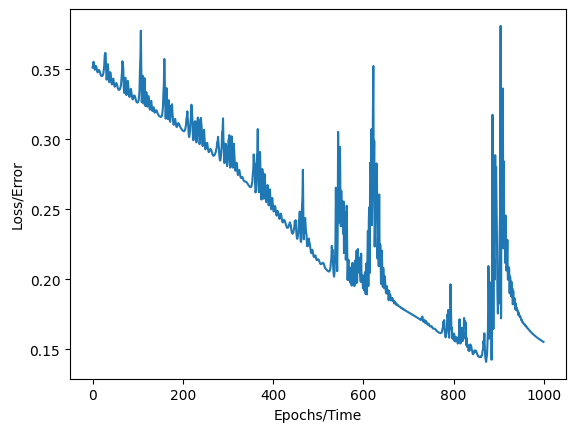

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), losses)
plt.ylabel("Loss/Error")
plt.xlabel("Epochs/Time")

In [ ]:
with torch.no_grad():
  y_eval = mlp.forward(X_test)
  y_eval = y_eval.squeeze(-1)
  loss = criterion(y_eval, y_test.float())


print(loss)

tensor(0.1557)


In [ ]:
correct = 0
with torch.no_grad():
  for i, data in enumerate(X_test):
    y_val = mlp.forward(data)

    #print(f"{i+1}.) {str(y_val)} \t {y_test[i]}")

    if round(y_val.item()) == y_test[i]:
      correct += 1


print(f"Correct: {correct} out of {i}")



Correct: 24773 out of 26372
